# Gett - Insights from Failed Orders

## Table of Contents
* [Assignment](#Assignment)
* [Data Description](#Data-Description)
* [Data Exploration](#Data-Exploration)
* [Question 1](#Question-1)
* [Question 2](#Question-2)
* [Question 3](#Question-3)
* [Question 4](#Question-4)
* [Question 5](#Question-5)

## Assignment

They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

Please complete the following tasks.

**1.** Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyze the resulting plot. Which category has the highest number of orders?

**2.** Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest failures? How can this be explained?

**3.** Plot the average time to cancellation with and without a driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

**4.** Plot the distribution of average ETA by hours. How can this plot be explained?

**5. BONUS Hexagons.** Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualize the hexes, coloring them by the number of fails on the map.

## Data Description
We have two data sets: data_orders and data_offers, both being stored in a CSV format. The data_orders data set contains the following columns:

**order_datetime:**  time of the order

**origin_longitude:** longitude of the order

**origin_latitude:** latitude of the order

**m_order_eta:** time before order arrival

**order_gk:** order number

**order_status_key:** status, an enumeration consisting of the following mapping:
        
        4 - cancelled by client,
        9 - cancelled by system, i.e., a reject
        
**is_driver_assigned_key:** whether a driver has been assigned

**cancellation_time_in_seconds:** how many seconds passed before cancellation


The data_offers data set is a simple map with 2 columns:

**order_gk:** order number, associated with the same column from the orders data set

**offer_id:** ID of an offer

## Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_offers = pd.read_csv('data_offers.csv')
data_offers.head(3)

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812


In [3]:
data_orders = pd.read_csv('data_orders.csv')
data_orders.head(3)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0


In [4]:
data = data_orders.merge(right = data_offers, how = 'inner', on = 'order_gk')
data.head(3)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174


We may be able to do something to improve the data quality a bit. For example, the values in order_status_key and is_driver_assigned_key are not informative of the contents, but are rather just keys that point to some internal description. We could replace their values with more informative information, like replacing the 1s in is_driver_assigned_key with the string Yes and the 0s with the string No. Same can be done for the order_status_key column. Moreover, the names of the columns sound a bit technical, but we can modify them.

In [5]:
data['is_driver_assigned'] = np.where(data['is_driver_assigned_key'] == 1, 'Yes', 'No')

data['order_status'] = np.where(data['order_status_key'] == 4, 'Client Cancelled', 'System Reject')

data.drop(columns = ['is_driver_assigned_key', 'order_status_key'], inplace = True)

data = data.rename(columns = {'order_datetime' : 'order_time'})

data.head(3)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,198.0,300050983403,Yes,Client Cancelled
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986179,No,Client Cancelled
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986174,No,Client Cancelled


## Question 1
Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyze the resulting plot. Which category has the highest number of orders?


In [6]:
data_question_1 = data.pivot_table(columns = ['is_driver_assigned', 'order_status'], values = 'order_gk',
                                   aggfunc = 'count')

data_question_1

is_driver_assigned               No                            Yes  \
order_status       Client Cancelled System Reject Client Cancelled   
order_gk                      13435          9469             8360   

is_driver_assigned                
order_status       System Reject  
order_gk                       4

<AxesSubplot:>

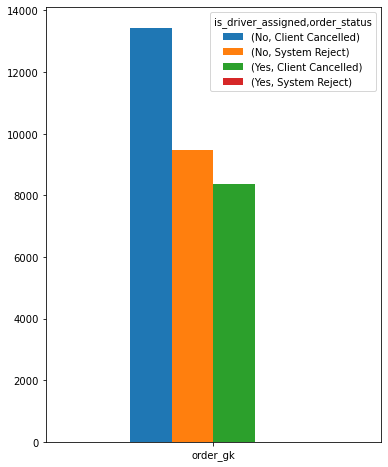

In [7]:
data_question_1.plot(kind = 'bar', subplots = False, figsize = (6,8), legend = True, rot = 0)

## Question 2
Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest failures? How can this be explained?

In [8]:
data['order_hour'] = data['order_time'].str.split(':').apply(lambda x: x[0])
data.head(3)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status,order_hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,198.0,300050983403,Yes,Client Cancelled,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986179,No,Client Cancelled,20
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986174,No,Client Cancelled,20


<AxesSubplot:title={'center':'Count of Failed Orders by Hour of day'}, xlabel='order_hour'>

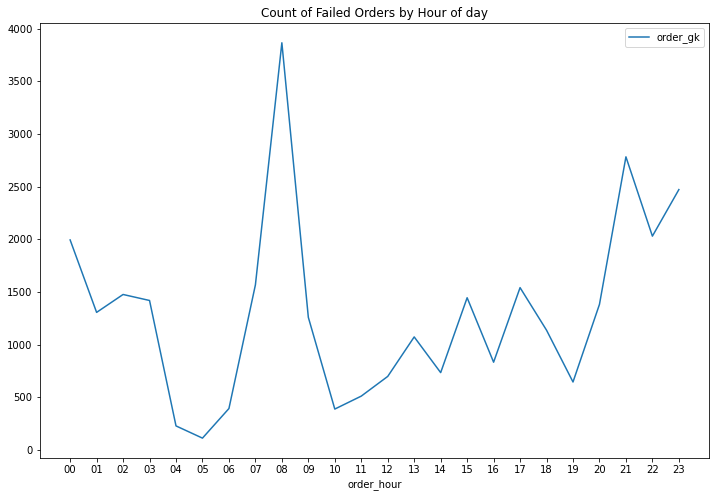

In [31]:
data.groupby(by = 'order_hour')['order_gk'].count().plot(figsize = (12, 8),legend = True, xticks = range(0, 24), 
                                                        title = 'Count of Failed Orders by Hour of day')

In [37]:
data_question_2 = data.groupby(by = ['order_hour' , 'is_driver_assigned' , 'order_status'])['order_gk'].count()
data_question_2

order_hour  is_driver_assigned  order_status    
00          No                  Client Cancelled     957
                                System Reject        706
            Yes                 Client Cancelled     326
                                System Reject          4
01          No                  Client Cancelled     633
                                                    ... 
22          No                  System Reject        660
            Yes                 Client Cancelled     415
23          No                  Client Cancelled    1144
                                System Reject        883
            Yes                 Client Cancelled     444
Name: order_gk, Length: 73, dtype: int64

<AxesSubplot:title={'center':'Count of Failed Orders Per Hour and Category'}, xlabel='order_hour'>

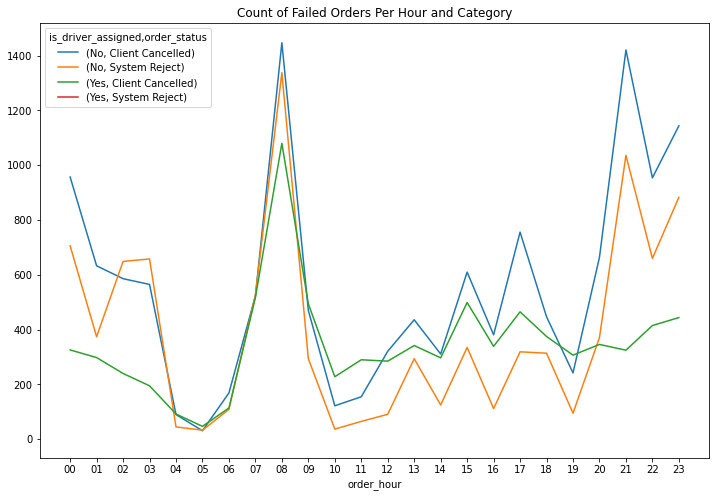

In [38]:
data_question_2.reset_index().pivot(index = 'order_hour', columns = ['is_driver_assigned', 'order_status'],
                                   values = 'order_gk').plot(xticks = range(0, 24), figsize = (12,8), 
                                                            title = 'Count of Failed Orders Per Hour and Category')

## Question 3
Plot the average time to cancellation with and without a driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

In [12]:
data_question_3 = data.groupby(by = ['order_hour', 'is_driver_assigned'])['cancellations_time_in_seconds'].mean()
data_question_3.head()

order_hour  is_driver_assigned
00          No                    115.126437
            Yes                   276.082822
01          No                    100.593997
            Yes                   296.312081
02          No                    121.305461
Name: cancellations_time_in_seconds, dtype: float64

<AxesSubplot:title={'center':'Average Time to Cancellation Per Hour and Driver Assignment'}, xlabel='order_hour'>

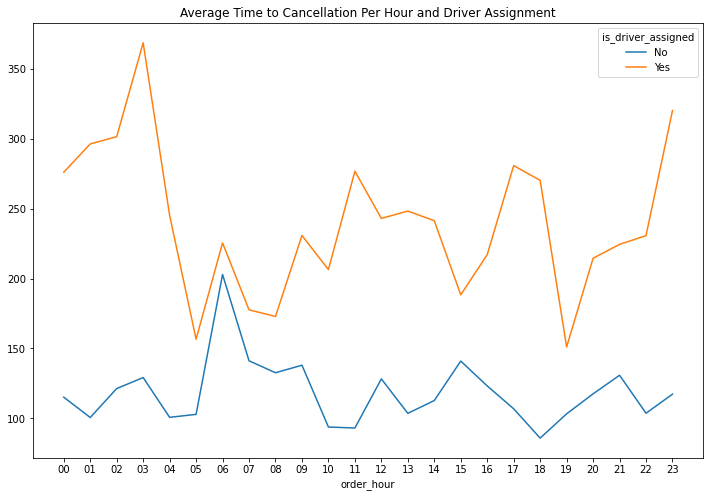

In [13]:
data_question_3.reset_index().pivot(index = 'order_hour', columns = 'is_driver_assigned',
                                    values = 'cancellations_time_in_seconds').plot(xticks = range(0,24),
                                                                                  figsize = (12,8),
                                                                                  title = 'Average Time to Cancellation Per Hour and Driver Assignment')

The average time to cancellation is higher on orders with an assigned driver than without, for each hour without exception. The peak occurs at 3 A.M. At this time there are a lot of client cancellations, so a logical explanation would be that clients have waited too long for the driver.

## Question 4
 Plot the distribution of average ETA by hours. How can this plot be explained?

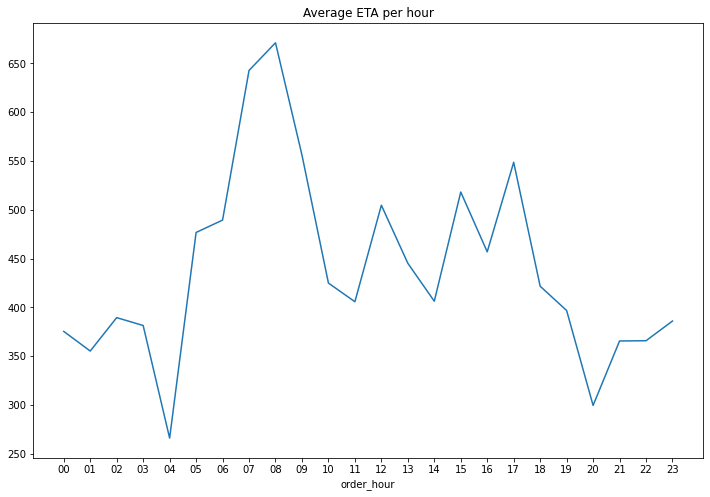

In [14]:
data_question_4 = data.groupby(by = 'order_hour')['m_order_eta'].mean().plot(figsize = (12,8),
                                                                             xticks = range(0,24),
                                                                             title = 'Average ETA per hour')

The line very closely matches the count of failed orders per hour, indicating that the number of failed orders increases as the average waiting time of the client increases.

## Question 5
Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualize the hexes, coloring them by the number of fails on the map.

h3 is an open-source framework developed by Uber. At its core, it is a geospatial analysis tool that provides a hexagonal, hierarchical, spatial index to gain insights from large geospatial databases. h3 covers the entire world with hexagons of different sizes. We can map the latitude and longitude attributes in our data to a hexagon ID, an internal h3 ID that points to a specific hexagon of a specific resolution (8, as required in the question).

That will result in each order having a new column, that we'll call hex_id. Next, we want to group the data by the hex_id and count the number of failed orders in it.

In [15]:
import h3
import folium

In [16]:
data['hex_id'] = data.apply(func = lambda row : h3.geo_to_h3(lat = row['origin_latitude'], 
                                                             lng = row['origin_longitude'],
                                                            resolution = 8), axis = 1)

In [17]:
data_question_5 = data.groupby(by = 'hex_id')['order_gk'].count().reset_index()
print('Shape:', data_question_5.shape)
data_question_5.head(3)

Shape: (139, 2)


,hex_id,order_gk
0,88195d2801fffff,65
1,88195d2803fffff,14
2,88195d2805fffff,10


To find the number of hexes that contain 80% of the orders, we will apply a cumulative percentage operation over the order_gk count column in the data_question_5 DataFrame. This consists of the following steps:

1. Sort the DataFrame by the count.

2. Find the total number (sum) of failed orders.

3. Apply the method cumsum to find the cumulative sum of the order-count column.

4. Divide by the total sum to generate percentages.

5. Filter to find the row that is closest to 80%.

In [18]:
data_question_5 = data_question_5.sort_values(by = 'order_gk')                         # Step 1

total_orders = data_question_5['order_gk'].sum()                                       # Step 2

data_question_5['cum_sum'] = data_question_5['order_gk'].cumsum()                      # Step 3
 
data_question_5['cum_perc'] = 100 * data_question_5['cum_sum'] / total_orders          # Step 4

data_question_5[data_question_5['cum_perc'] <= 80]                                     # Step 5

,hex_id,order_gk,cum_sum,cum_perc
137,88195d74d5fffff,1,1,0.003198
135,88195d74d1fffff,1,2,0.006396
79,88195d2aebfffff,1,3,0.009594
11,88195d282bfffff,1,4,0.012793
122,88195d3993fffff,1,5,0.015991
...,...,...,...,...
61,88195d2a27fffff,1295,15628,49.980811
20,88195d284dfffff,1937,17565,56.175643
91,88195d2b19fffff,1960,19525,62.444032
87,88195d2b11fffff,2191,21716,69.451196


There are 137 rows in the final output, and 139 rows in the original grouped DataFrame, meaning that 137 hexagons contain around 80% of data, and only 2 hexagons contain the other 20%!

In [19]:
map = folium.Map(location = [data['origin_latitude'].mean(), data['origin_longitude'].mean()],
                zoom_start = 8.5, tiles = 'cartodbpositron')

To be able to draw the hexagons, we need to transform them in a format that is readable by folium, and one solution for that is the geojson package, which contains methods for manipulation of formats (JSONs) that represent geographic objects. It is a bit specialized than JSON, in that it contains some complex objects, such as points, polygons, geometry collections, etc.

In the cell below we apply a custom to_geojson function that transforms the hex_id we have for each hexagon into a proper geojson object that can be read into folium. For each row (each order) we create a geojson.Feature object that stores transformed geometric boundaries for each hexagon. We collect all such objects into a FeatureCollection and dump them into a JSON-formatted string.

In [20]:
import json
import geojson

def to_geojson(row):
    geometry = {
        'type' : 'Polygon',
        'coordinates' : [h3.h3_to_geo_boundary(h = row["hex_id"], geo_json=True)]
    } 
    return geojson.Feature(id = row["hex_id"], geometry = geometry, properties = {"order_gk": row["order_gk"]})



geojsons = data_question_5.apply(func = to_geojson, axis = 1).values.tolist()
geojson_str: str = json.dumps(geojson.FeatureCollection(geojsons))

In [21]:
colormap = plt.cm.get_cmap(name = "plasma")

max_order_gk = data_question_5["order_gk"].max()

min_order_gk = data_question_5["order_gk"].min()

In [26]:
import matplotlib

folium.GeoJson(data = geojson_str, style_function = lambda f: {
    "fillColor": matplotlib.colors.to_hex(
        colormap((f["properties"]["order_gk"] - min_order_gk) / (max_order_gk - min_order_gk))),
    "weight": 1,
    "fillOpacity": 0.7
}).add_to(map)

In [39]:
map

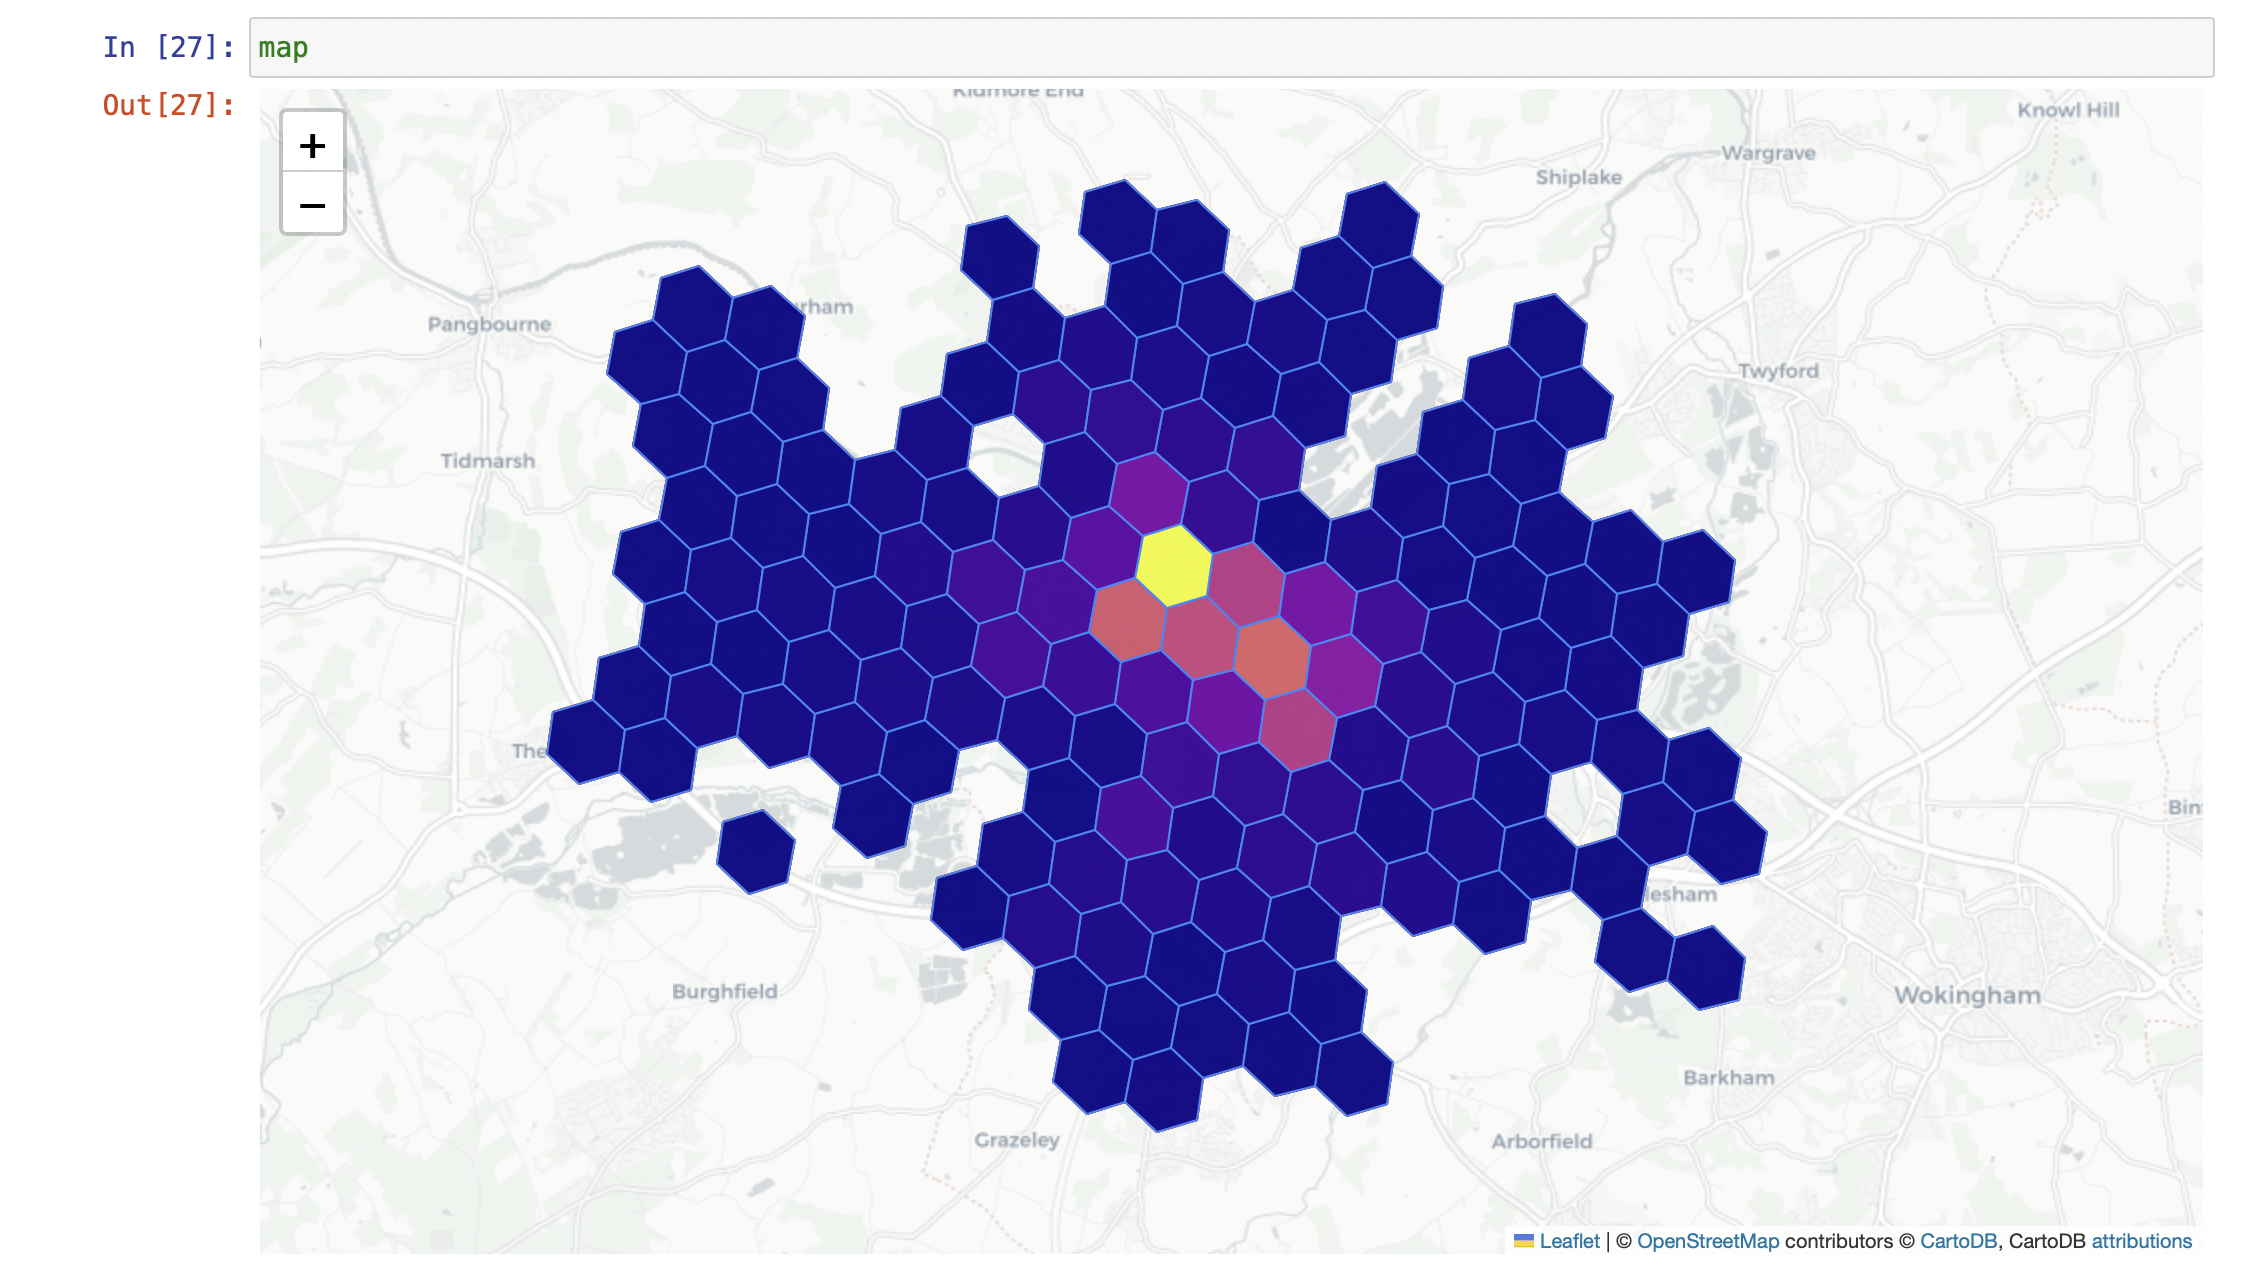

Since the output of the map is not visible on Github, I have attached the output as a photo.